# Purpose of this file:

The file is just used for debugging purposes. It is used to check if the code is working as expected.

In [1]:
# importing modules
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def parse_file(file_path: str):
    """
    Parse the file and return the abstract syntax tree

    Args:
    file_path: The path to the file to be parsed

    Returns:
    The abstract syntax tree of the file
    """
    with open(file_path, 'r') as f:
        tree = ast.parse(f.read())
    return tree

In [4]:
def extract_functions(tree):
    """ 
    Extract all the functions from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions with the function name as the key and the function's
    """
    functions = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls" : [],
                'line' : node.lineno
            }
    return functions

In [8]:
def analyze_function_calls(tree, functions):
    """ 
    Analyze the function calls in the abstract syntax tree and update the functions dictionary

    Args:
    tree: The abstract syntax tree of the file
    functions: The dictionary of functions with the function name as the key and the function's

    Returns:
    None
    """
    for node in ast.walk(tree):
        if isinstance(node, ast.Call) and isinstance(node.func, ast.Name):
            caller = None
            for parent in ast.walk(tree):
                if isinstance(parent, ast.FunctionDef) and node in ast.walk(parent):
                    caller = parent.name
                    break
            if caller and node.func.id in functions:
                functions[caller]['calls'].append(node.func.id)

In [9]:
def create_graph(functions):
    """ 
    Create a directed graph of the functions and their calls

    Args:
    functions: The dictionary of functions with the function name as the key and the function's

    Returns:
    A directed graph of the functions and their calls
    """
    G = nx.DiGraph()
    for func, data in functions.items():
        G.add_node(func)
        for call in data['calls']:
            G.add_edge(func, call)
    return G

In [10]:
def visualize_graph(G):
    """ 
    Visualize the directed graph of the functions and their calls

    Args:
    G: A directed graph of the functions and their calls

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))  # Increase figure size
    pos = nx.spring_layout(G, k=0.9, iterations=50)  # Adjust layout for more spacing
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    
    # Add edge labels (function names)
    edge_labels = {(u, v): u for (u, v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Function Call Graph", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

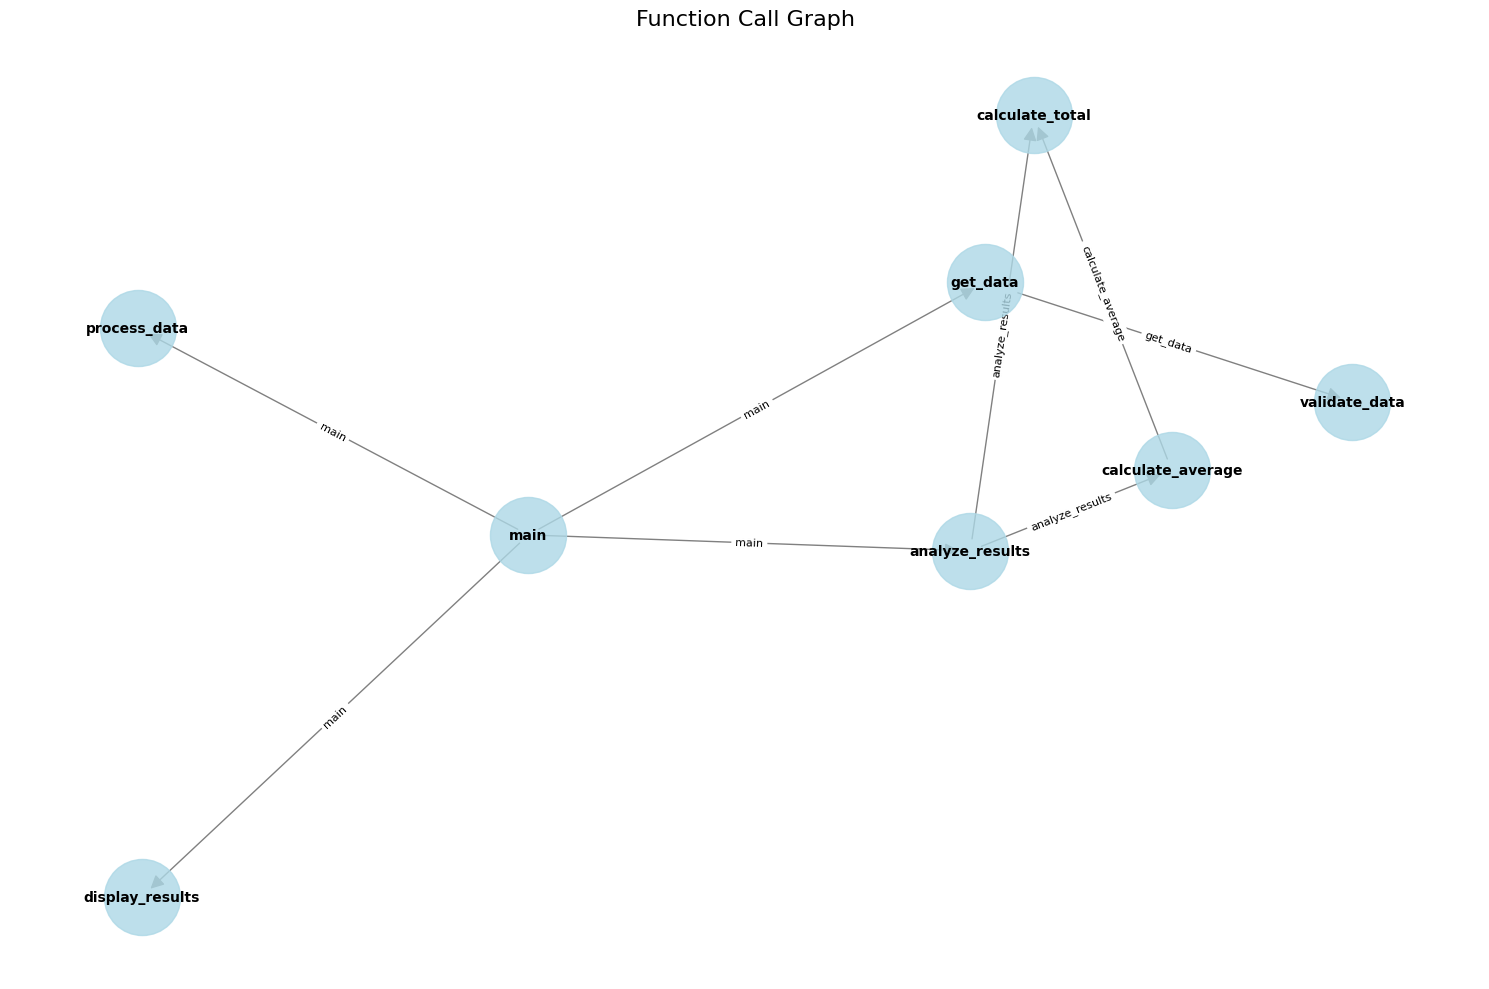

In [11]:
def main():
    """ 
    Main function to run the program
    """
    file_path = input("Enter the path to the Python file: ")
    tree = parse_file(file_path)
    functions = extract_functions(tree)
    analyze_function_calls(tree, functions)
    G = create_graph(functions)
    visualize_graph(G)

if __name__ == "__main__":
    main()

## For the whole directory

In [25]:
# importing modules
import os
import ast
import time
import numpy as np
import igraph as ig
import networkx as nx
import plotly.graph_objects as go

In [26]:
def parse_directory(directory_path: str):
    """  
    Parse the directory and return all the python files in that directory

    Args:
    directory_path: The path to the directory

    Returns:
    A list of all the python files in the directory
    """
    python_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".py"):
                python_files.append(os.path.join(root, file))
    return python_files

In [27]:
def parse_file(file_path: str):
    """
    Parse the file and return the abstract syntax tree

    Args:
    file_path: The path to the file to be parsed

    Returns:
    The abstract syntax tree of the file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        tree = ast.parse(f.read())
    return tree

In [28]:
def extract_functions(tree):
    """ 
    Extract all the functions from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions with the function name as the key and the function's
    """
    functions = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls" : [],
                'line' : node.lineno,
                'file': None
            }
    return functions

In [29]:
def extract_functions_and_imports(tree):
    """ 
    Extract all the functions and imported modules from the abstract syntax tree

    Args:
    tree: The abstract syntax tree of the file

    Returns:
    A dictionary of functions and imports with the function name as the key and the function's data
    """
    functions = {}
    imports = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions[node.name] = {
                "calls": [],
                'line': node.lineno,
                'file': None
            }
        elif isinstance(node, ast.Import) or isinstance(node, ast.ImportFrom):
            for alias in node.names:
                imports.add(alias.name.split('.')[0])  # Add imported module names
    return functions, imports

In [30]:
def analyze_function_calls(tree, functions, omit_list):
    """ 
    Analyze the function calls in the abstract syntax tree and update the functions dictionary

    Args:
    tree: The abstract syntax tree of the file
    functions: The dictionary of functions with the function name as the key and the function's
    omit_list: A list of functions to omit from the analysis

    Returns:
    None
    """
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            caller = None
            for parent in ast.walk(tree):
                if isinstance(parent, ast.FunctionDef) and node in ast.walk(parent):
                    caller = parent.name
                    break
            if caller and caller in functions and caller not in omit_list:
                if isinstance(node.func, ast.Name):
                    called_func = node.func.id
                    if called_func not in omit_list:
                        functions[caller]['calls'].append(called_func)
                elif isinstance(node.func, ast.Attribute):
                    called_func = node.func.attr
                    if isinstance(node.func.value, ast.Name):
                        object_name = node.func.value.id
                        if called_func not in omit_list:
                            # Append the method call (e.g., object.method)
                            functions[caller]['calls'].append(f"{object_name}.{called_func}")
                    else:
                        if called_func not in omit_list:
                            functions[caller]['calls'].append(called_func)
                else:
                    if hasattr(node.func, 'id') and node.func.id not in omit_list:
                        functions[caller]['calls'].append(node.func.id)
                    elif hasattr(node.func, 'attr') and node.func.attr not in omit_list:
                        functions[caller]['calls'].append(node.func.attr)

In [31]:
def create_graph(functions, imports, file_paths, omit_list):
    """ 
    Create a directed graph of the functions, their calls, and imports

    Args:
    functions: The dictionary of functions with the function name as the key and the function's data
    imports: The set of imported modules
    file_paths: A list of file paths
    omit_list: A list of functions to omit from the analysis

    Returns:
    A directed graph of the functions, their calls, and imports
    """
    G = nx.DiGraph()
    
    for file_path in file_paths:
        module_name = os.path.basename(file_path).replace('.py', '')
        for func, data in functions.items():
            if data['file'] == file_path and func not in omit_list:
                G.add_node(func, module=module_name)
                for call in data['calls']:
                    if call in functions and call not in omit_list:
                        G.add_edge(func, call)

    # Add imported modules as isolated nodes
    for module in imports:
        G.add_node(module, module='import')
    
    return G

In [32]:
def visualize_graph_3d(G):
    """ 
    Visualize the 3D directed graph of the functions, their calls, and imports

    Args:
    G: A directed graph of the functions, their calls, and imports

    Returns:
    None
    """
   # Convert NetworkX graph to igraph
    ig_graph = ig.Graph.from_networkx(G)

    # Get the layout
    layt = ig_graph.layout_fruchterman_reingold(dim=3)

    # Extract node positions
    node_x, node_y, node_z = zip(*layt)

    # Create node trace
    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers+text',
        text=list(G.nodes()),
        textposition="top center",
        textfont=dict(size=10, color='black'),
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Color node points by the number of connections
    node_adjacencies = []
    node_text = []
    for node, adjacencies in G.adjacency():
        node_adjacencies.append(len(adjacencies))
        node_text.append(f"Function: {node}<br># of connections: {len(adjacencies)}")

    node_trace.marker.color = node_adjacencies
    node_trace.hovertext = node_text

    # Create edge traces with arrows
    edge_traces = []
    for edge in G.edges():
        start = layt[list(G.nodes()).index(edge[0])]
        end = layt[list(G.nodes()).index(edge[1])]
        x0, y0, z0 = start
        x1, y1, z1 = end
        
        # Calculate the direction vector
        dx, dy, dz = x1 - x0, y1 - y0, z1 - z0
        
        # Normalize the direction vector
        length = np.sqrt(dx**2 + dy**2 + dz**2)
        ux, uy, uz = dx/length, dy/length, dz/length
        
        # Calculate the midpoint
        mx, my, mz = (x0 + x1) / 2, (y0 + y1) / 2, (z0 + z1) / 2
        
        # Create the line trace
        line_trace = go.Scatter3d(
            x=[x0, x1],
            y=[y0, y1],
            z=[z0, z1],
            mode='lines',
            line=dict(color='#888', width=2),
            hoverinfo='none'
        )
        
        # Create the arrow trace
        arrow_trace = go.Cone(
            x=[mx], y=[my], z=[mz],
            u=[ux], v=[uy], w=[uz],
            sizemode="absolute",
            sizeref=0.15,
            showscale=False,
            colorscale=[[0, '#888'], [1, '#888']],
            anchor="tip"
        )
        
        edge_traces.extend([line_trace, arrow_trace])

    # Create the figure
    fig = go.Figure(data=[*edge_traces, node_trace],
                    layout=go.Layout(
                        title='3D Function Call Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=0),
                        scene=dict(
                            xaxis=dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title=''),
                            yaxis=dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title=''),
                            zaxis=dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title=''),
                        ),
                        annotations=[
                            dict(
                                showarrow=False,
                                text="",
                                xref="paper",
                                yref="paper",
                                x=0,
                                y=0.1,
                                xanchor="left",
                                yanchor="bottom",
                                font=dict(size=14)
                            )
                        ]
                    )
                )

    return fig

In [33]:
def main():
    directory_path = input("Enter the path to the directory: ")
    print(f"The input directory is: {directory_path}")
    omit_list = input("Enter the functions to omit (comma-separated): ").split(',')
    print(f"The functions to omit are: {omit_list}")

    omit_list = [func.strip() for func in omit_list]

    python_files = parse_directory(directory_path)

    functions = {}
    imports = set()
    G = nx.DiGraph()

    fig = go.Figure()

    for i, file_path in enumerate(python_files):
        tree = parse_file(file_path)
        file_functions, file_imports = extract_functions_and_imports(tree)
        
        for func_name, func_data in file_functions.items():
            func_data['file'] = file_path
        
        functions.update(file_functions)
        imports.update(file_imports)
        analyze_function_calls(tree, functions, omit_list)

        G = create_graph(functions, imports, python_files[:i+1], omit_list)
        fig = visualize_graph_3d(G)

        # Update the figure
        fig.update_layout(title_text=f"Processing file {i+1}/{len(python_files)}: {os.path.basename(file_path)}")
        fig.show()

        # Pause to allow for visualization
        time.sleep(2)

    # Final visualization
    fig = visualize_graph_3d(G)
    fig.update_layout(title_text="Final 3D Function Call Graph")
    fig.show()

if __name__ == "__main__":
    main()

The input directory is: C:\Users\Vishal\Github\CodeFlowMapper\testing-directories
The functions to omit are: ['']
